# **Neural Matrix Factorization or NeuMF**

Combining the General Matrix Factorization(GMF) and the Multi Layer Perceptron(MLP) to form the Neural Matrix Factorization(NeuMF) and integrate it into a single model to minimize loss further and give the best and the most accurate results.

Importing all the necessary packages and libraries for the model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization,Flatten,Dot
from tensorflow.keras.optimizers import Adam,Nadam,Ftrl,SGD,Adadelta,Adamax,Adagrad,RMSprop
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, lecun_uniform,he_uniform
import math
import pandas as pd

Dataset is being read into the code and the columns under consideration i.e., U_ID, P_ID and RATING are used to create the dataframe.

In [ ]:
col_list = ["U_ID", "P_ID", "RATING"]
dataset = pd.read_csv('rating.csv',usecols=col_list, sep='\t',dtype='int')

This block and the next block of code deals with extracting the unique User IDs from the dataset and mapping them with their index number and storing it in a dictionary

In [ ]:
#to get the unique user ids from dataset
user_ids = dataset['U_ID'].values
unique_ids = np.unique(user_ids)
id_dict = {id: counter for counter, id in enumerate(unique_ids)}
#enumerate(unique_ids)
dataset['U_ID'] = dataset['U_ID'].apply(lambda x: id_dict[x])

In [ ]:
#to get the unique product ids from dataset
product_ids = dataset['P_ID'].values
unique_ids = np.unique(product_ids)
#create a dictionary of users with key value from 0 to #users
id_dict = {id: counter for counter, id in enumerate(unique_ids)}
dataset['P_ID'] = dataset['P_ID'].apply(lambda x: id_dict[x])

Makes the train and test data for our model. Also the latent factors for the matrix factorization is taken to be 20.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
n_users = len(dataset.U_ID.unique())
n_movies = len(dataset.P_ID.unique())
n_latent_factors=20

MF input for users

In [ ]:
user_input = Input(shape=[1], name="User-Input")
user_embedding_mf = Embedding(n_users+1, 20, name="User-Embedding_mf")(user_input)
user_vec_mf = Flatten(name="Flatten-Users_mf")(user_embedding_mf)

MLP input for users

In [ ]:
user_embedding_mlp = keras.layers.Embedding(n_users, n_latent_factors, 
                                          embeddings_initializer="uniform", 
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='User-Embedding_mlp')(user_input)
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers_mlp')(user_embedding_mlp)

MF input for movies

In [ ]:
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding_mf = Embedding(n_movies+1, 20, name="Movie-Embedding_mf")(movie_input)
movie_vec_mf = Flatten(name="FlattenMovies_mf")(movie_embedding_mf)

MLP input for movies

In [ ]:

movie_embedding_mlp = keras.layers.Embedding(n_movies, n_latent_factors, 
                                          embeddings_initializer="uniform", 
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='Movie-Embedding_mlp')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies_mlp')(movie_embedding_mlp)

MF Product


In [ ]:
mf = Dot(name="Dot-Product", axes=1)([movie_vec_mf, user_vec_mf])

Concatenating the MLP input for both movies and users and perform the MLP through Deep Neural Networks.

In [ ]:
concat = keras.layers.concatenate([movie_vec_mlp, user_vec_mlp])
#mlp with 6 layers 
mlp = concat
for i in range(6,-1,-1):
    if i == 0:
      mlp = Dense(8**i, activation='softmax', kernel_initializer='lecun_uniform',
                  name="output")(mlp)
    else:
      mlp = Dense(8*2**i, activation='relu', kernel_initializer='he_uniform')(mlp)
      if i > 5:
        mlp = BatchNormalization()(mlp)
        mlp = Dropout(0.05)(mlp)

Concatenation of MLP and Matrix Factorisation

In [ ]:
combine_mlp_mf = keras.layers.concatenate([mf, mlp])
result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)
result = keras.layers.Dense(1,name='Prediction')(deep_combine)

Tuning and training the model. Taking Epochs = 10 and Optimiser = Nadam , and the loss factor as 'Mean Squared Error' and other metrics like mae to calculate the loss.

In [ ]:
model = keras.Model([user_input, movie_input], result)
model.compile('nadam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit([train.U_ID, train.P_ID], train.RATING, epochs=10, verbose=1, validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


6392/6392 [==============================] - 507s 79ms/step - loss: 1.1606 - mae: 0.8285 - mse: 1.1606 - val_loss: 1.1211 - val_mae: 0.8151 - val_mse: 1.1211
Epoch 2/10
6392/6392 [==============================] - 496s 78ms/step - loss: 0.9288 - mae: 0.7068 - mse: 0.9288 - val_loss: 1.2057 - val_mae: 0.8508 - val_mse: 1.2057
Epoch 3/10
6392/6392 [==============================] - 497s 78ms/step - loss: 0.5550 - mae: 0.5155 - mse: 0.5550 - val_loss: 1.3299 - val_mae: 0.9032 - val_mse: 1.3299
Epoch 4/10
6392/6392 [==============================] - 491s 77ms/step - loss: 0.3362 - mae: 0.3849 - mse: 0.3362 - val_loss: 1.4087 - val_mae: 0.9414 - val_mse: 1.4087
Epoch 5/10
6392/6392 [==============================] - 494s 77ms/step - loss: 0.2170 - mae: 0.3035 - mse: 0.2170 - val_loss: 1.4548 - val_mae: 0.9418 - val_mse: 1.4548
Epoch 6/10
6392/6392 [==============================] - 494s 77ms/step - loss: 0.1559 - mae: 0.2611 - mse: 0.1559 - val_loss: 1.4971 - val_mae: 0.9696 - val_mse: 1.49

A line graph to display the decreasing rate of the loss with the increase in epochs.

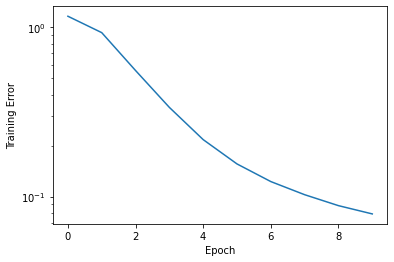

In [ ]:
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('books_read.png')

Gives the summary of the model

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie-Input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding_mlp (Embedding) (None, 1, 20)        2102280     Movie-Input[0][0]                
__________________________________________________________________________________________________
User-Embedding_mlp (Embedding)  (None, 1, 20)        147500      User-Input[0][0]                 
_______________________________________________________________________________________

To visualise the entire model.

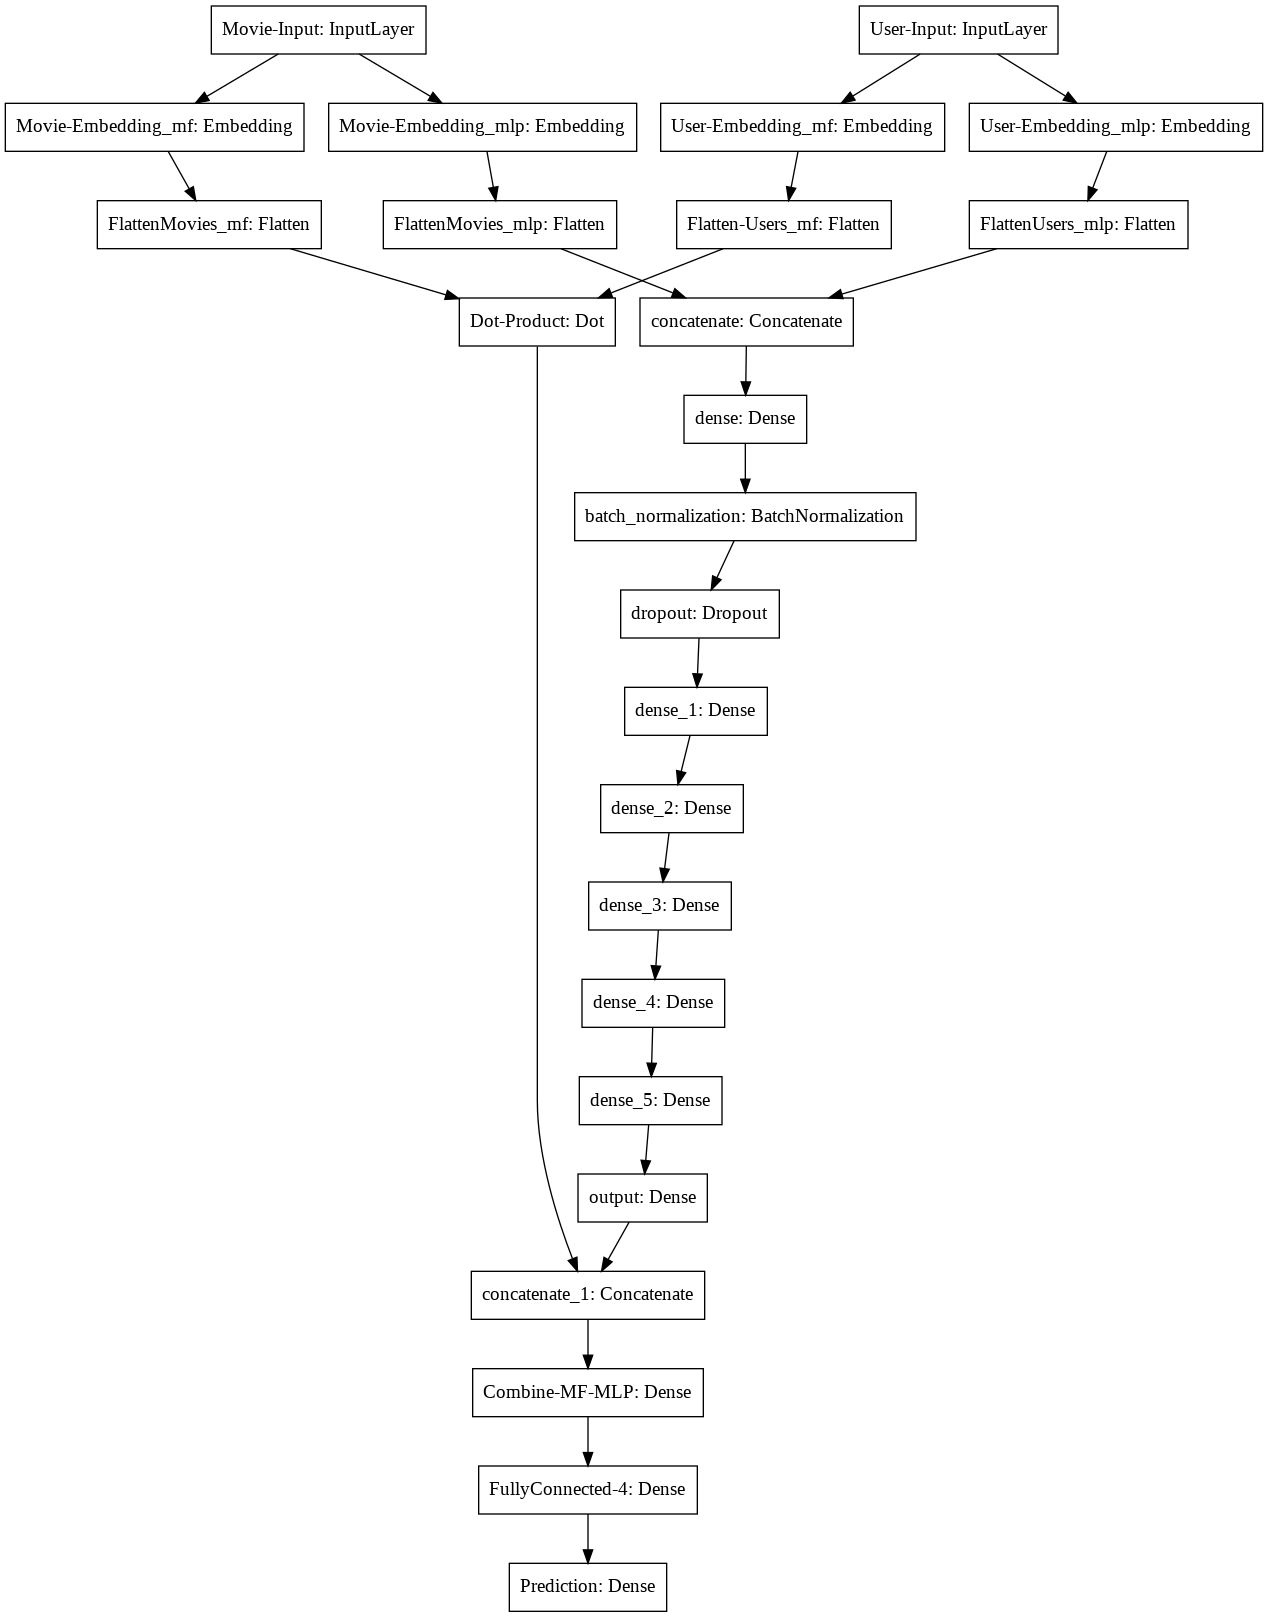

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

Evaluates the test portion of the dataset and gives the loss in terms of mae and mse.

In [ ]:
finalresults = model.evaluate([test.U_ID,test.P_ID],test.RATING, batch_size=1)

56818/56818 [==============================] - 368s 6ms/step - loss: 1.5200 - mae: 0.9699 - mse: 1.5200


Retrieves a layer based on either its name (unique) or index.

In [ ]:
#get_weights() Returns the current weights of the layer.
product_embedding_learnt = model.get_layer(name='Movie-Embedding_mf').get_weights()[0]

In [ ]:
user_embedding_learnt = model.get_layer(name='User-Embedding_mf').get_weights()[0]

**Param** *user_id*: The unique U_ID

**Param** *number_of_products*: (default = 5), The number of predictions to choose based on relevancy


In [ ]:
def recommend(user_id, number_of_products=5):
  products = user_embedding_learnt[user_id]@product_embedding_learnt.T
  mids = np.argpartition(products, -number_of_products)[-number_of_products:]
  return mids

Displaying recommendations

In [ ]:
recommend(user_id=1)

array([38374, 19534, 24714, 28167, 93116])